In [237]:
import geopandas as gpd
import pandas as pd
import requests
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely.geometry import LineString, Point, Polygon, MultiLineString

In [268]:
coords

In [ ]:
jaipur_region = gpd.read_file("data/Jaipur_District_Block/Jaipur_District_Block.shp", driver="ESRI Shapefile", crs="EPSG:4326")
jaipur_region = jaipur_region.dissolve()
jaipur_polygon = jaipur_region.geometry.values[0]
coords = jaipur_polygon.exterior.coords
polygon_string = " ".join([f"{lat} {lon}" for lon, lat in coords])
polygon_string

'26.550610000000034 75.7844770000001 26.54824000000005 75.776352 26.547621999999897 75.76877600000003 26.539989000000013 75.76754699999995 26.53662999999991 75.768737 26.534710999999938 75.77294900000007 26.530099999999983 75.7789070000001 26.52210000000011 75.76373200000005 26.521651000000173 75.75694299999992 26.516411000000044 75.75572100000015 26.503190000000103 75.76198600000009 26.496232000000113 75.76670000000004 26.489171000000038 75.76822700000017 26.48461099999995 75.7653890000001 26.4766109999999 75.76757700000013 26.471300000000202 75.76567200000007 26.470710000000146 75.76420600000009 26.470090000000006 75.76264300000018 26.470848999999923 75.75798900000004 26.473450000000103 75.75296100000014 26.473150999999966 75.744157 26.45704000000009 75.74315600000004 26.45124000000008 75.73922700000011 26.453480000000056 75.73348300000004 26.463640000000037 75.72911900000017 26.469739000000096 75.72458600000002 26.449099000000125 75.707299 26.449940000000076 75.6929010000001 26.4547

In [275]:
# Build the Overpass  query
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
(
  // Get bus, train, and metro routes
  relation["route"~"bus|trolleybus|train|light_rail|tram|subway|metro|rail"](poly:"{}");

  // Get stops/stations
  node["highway"="bus_stop"](poly:"{}");
  node["railway"="station"](poly:"{}");
  node["railway"="subway_entrance"](poly:"{}");

);
out body;
>;
out skel qt;
""".format(polygon_string, polygon_string, polygon_string, polygon_string)

# Make the API call
response = requests.post(overpass_url, data={'data': overpass_query}) # Send the POST request
if response.status_code != 200:
    raise Exception(f"Overpass API request failed with status code {response.status_code}")
data = response.json() # Parse response as JSON

STATION

In [277]:
nodes_bus = []
nodes_train = []
nodes_metro = []
for el in data['elements']:
  if 'tags' not in el:
    continue
  if el['type'] == 'node':
    if el['tags'].get('highway') == 'bus_stop':
      nodes_bus.append(el)
    elif el['tags'].get('railway') == 'station':
      if el['tags'].get('train') == 'yes' or el['tags'].get('station') == 'train':
        nodes_train.append(el)
      elif el['tags'].get('subway') == 'yes':
        nodes_metro.append(el)
      
print(f"Found {len(nodes_bus)} bus stops, {len(nodes_train)} train stations, and {len(nodes_metro)} metro stations.")

Found 400 bus stops, 44 train stations, and 11 metro stations.


In [278]:
def get_gdfstop_from_el(relation):
  df = pd.json_normalize(relation, sep='_')
  df = df.rename(columns=lambda x: x.replace('tags_', ''))
  geometry = [Point(xy)for xy in zip(df['lon'], df['lat'])]
  gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
  gdf = gdf.dropna(axis=1, how='all')
  gdf = gdf[['name', 'geometry']]
  return gdf

In [279]:
gdf_bus_stations = get_gdfstop_from_el(nodes_bus)
gdf_bus_stations.head()

,name,geometry
0,Ghat ki guni,POINT (75.86123 26.89480)
1,Ramgarh Mod,POINT (75.83951 26.94410)
2,Harmada,POINT (75.76933 27.01505)
3,Theekariya Mod,POINT (75.63315 26.84876)
4,Kalyan Nagar,POINT (75.79430 26.82628)


In [280]:
gdf_train_stations = get_gdfstop_from_el(nodes_train)
gdf_train_stations = gdf_train_stations[gdf_train_stations['name'].notna()]
gdf_train_stations

,name,geometry
0,Getor Jagatpura,POINT (75.83202 26.83700)
1,Dahar-Ka-Balaji,POINT (75.76611 26.94451)
2,Govindgarh Malikpur,POINT (75.64619 27.24036)
3,Banskho,POINT (76.16842 26.85731)
4,Peeplee Ka Bas,POINT (75.26892 26.91064)
5,Bhanwsa,POINT (75.21735 26.83312)
6,Gandhi Nagar Jaipur,POINT (75.79922 26.87280)
7,Phulera Junction,POINT (75.24602 26.87361)
8,Kanakpura,POINT (75.70328 26.92920)
9,Bindayaka,POINT (75.65159 26.92362)


In [281]:
gdf_metro_stations = get_gdfstop_from_el(nodes_metro)
gdf_metro_stations = gdf_metro_stations[gdf_metro_stations['name'] != 'Ambabadi Metro (u/c)']
gdf_metro_stations

,name,geometry
1,Sindhi Camp,POINT (75.79982 26.92268)
2,Railway Station,POINT (75.79013 26.91811)
3,Civil Lines,POINT (75.78125 26.90968)
4,Chandpole,POINT (75.80789 26.92660)
5,Choti Chaupar,POINT (75.81846 26.92473)
6,Badi Chaupar,POINT (75.82682 26.92296)
7,Manasarovar,POINT (75.75024 26.87944)
8,Shyam Nagar,POINT (75.77063 26.89648)
9,Vivek Vihar,POINT (75.76841 26.88845)
10,New Aatish Market,POINT (75.76447 26.88015)


In [282]:
# COnvert to Geojson
gdf_bus_stations.to_file("../../public/data/mapMain/bus_stops.geojson", driver='GeoJSON')
gdf_train_stations.to_file("../../public/data/mapMain/train_stations.geojson", driver='GeoJSON')
gdf_metro_stations.to_file("../../public/data/mapMain/metro_stations.geojson", driver='GeoJSON')

ROUTE

In [283]:
bus_route_types = ['bus', 'trolleybus']
rail_route_types = ['train','rail']
subway_route_types = ['subway', 'metro','tram','light_rail']

relations_bus = []
relations_train = []
relations_subway = []
for el in data['elements']:
  if 'tags' not in el:
    continue
  if el['type'] == 'relation':
    if el['tags'].get('route') in rail_route_types:
      relations_train.append(el)
    elif el['tags'].get('route') in subway_route_types:
      relations_subway.append(el)
    elif el['tags'].get('route') in bus_route_types:
      relations_bus.append(el)
print(f"Found {len(relations_train)} train routes, {len(relations_subway)} subway routes, and {len(relations_bus)} bus routes.")

Found 6 train routes, 2 subway routes, and 38 bus routes.


In [284]:
# Print details about the first route
modes = [relations_bus, relations_train, relations_subway]
for mode in modes:
    if mode:
        first_route = mode[0]
        tags = first_route.get('tags', {})
        print(f"First route of {first_route['tags'].get('route')}:")
        print(f"  Name: {first_route['tags'].get('name', 'N/A')}")
        print(f"  Ref: {first_route['tags'].get('ref', 'N/A')}")
        print(f"  Operator: {first_route['tags'].get('operator', 'N/A')}")
        print(list(tags.keys()))

First route of bus:
  Name: Bus 7: Khirni Fatak - Transport Nagar
  Ref: 7
  Operator: JCTSL
['from', 'interval', 'name', 'opening_hours', 'operator', 'public_transport', 'ref', 'roundtrip', 'route', 'to', 'type']
First route of train:
  Name: Double Decker Express 12985: Jaipur → Delhi Sarai Rohilla
  Ref: 12985
  Operator: North Western Railway
['check_date', 'duration', 'from', 'name', 'network', 'operator', 'passenger', 'public_transport:version', 'ref', 'route', 'sleeping_car', 'to', 'type']
First route of subway:
  Name: Pink Line (Mansarovar --> Badi Chaupar)
  Ref: Pink Line
  Operator: JMRC
['colour', 'duration', 'from', 'interval', 'interval:conditional', 'name', 'name:hi', 'network', 'network:wikidata', 'opening_hours', 'operator', 'public_transport:version', 'ref', 'route', 'to', 'type', 'wikidata', 'wikipedia']


In [285]:
def get_gdfroute_from_rel(relation):
    """
    Convert an Overpass relation to a GeoDataFrame.
    """
    route_geoms = []
    route_labels = []
    route_from = []
    route_to = []
    route_network = []
    route_operator = []
    route_interval = []
    
    nodes = {el['id']: el for el in data['elements'] if el['type'] == 'node'}
    ways = {el['id']: el for el in data['elements'] if el['type'] == 'way'}

    for rel in relation:
        # Get route number (ref) or fall back to 'name'
      ref = rel.get('tags', {}).get('ref') or rel.get('tags', {}).get('name') or f"relation {rel['id']}"
      operator = rel.get('tags', {}).get('operator')
      interval = rel.get('tags', {}).get('interval')
      from_ = rel.get('tags', {}).get('from')
      to_ = rel.get('tags', {}).get('to')
      network = rel.get('tags', {}).get('network')

      # Find member ways
      member_way_ids = [m['ref'] for m in rel['members'] if m['type'] == 'way']
      coords = []
      for wid in member_way_ids:
          way = ways.get(wid)
          if not way:
              continue
          line_coords = []
          for nid in way['nodes']:
              node = nodes.get(nid)
              if node:
                  line_coords.append((node['lon'], node['lat']))
          if len(line_coords) > 1:
              coords.append(LineString(line_coords))
      
      if coords:
          # Combine into MultiLine if more than one segment, else just use the LineString
          geom = coords[0] if len(coords) == 1 else gpd.GeoSeries(coords).unary_union
          route_geoms.append(geom)
          route_labels.append(ref)
          route_operator.append(operator)
          route_interval.append(interval)
          route_from.append(from_)
          route_to.append(to_)
          route_network.append(network)

        
    gdf = gpd.GeoDataFrame({
        'route': route_labels,
        'operator': route_operator,
        'interval': route_interval,
        'geometry': route_geoms,
        'from': route_from,
        'to': route_to,
        'network': route_network,

    }, crs="EPSG:4326")
    
    return gdf

In [287]:

gdf_bus = get_gdfroute_from_rel(relations_bus)
# filter long distance bus and dedupe
gdf_bus = gdf_bus[gdf_bus['route']!= 'Jaipur To Bharatpur (RSRTC Express)']
gdf_bus = gdf_bus.groupby('route').first().reset_index()  # dedupe by route
# get color
route_to_idx = {route: i for i, route in enumerate(gdf_bus['route'].unique())}
cmap = plt.get_cmap('tab20')
gdf_bus['color'] = gdf_bus['route'].map(lambda route: mcolors.to_hex(cmap(route_to_idx[route])))
gdf_bus


,route,operator,interval,geometry,from,to,network,color
0,1,JCTSL,None,"MULTILINESTRING ((75.78808 27.04376, 75.78825 ...",Bheru Khejda,Galta,Jaipur City Bus,#1f77b4
1,1 Mini/1,JCTSL,00:30,"MULTILINESTRING ((75.77035 26.99856, 75.77025 ...",Galta Gate,Todi,None,#aec7e8
2,11,JCTSL,None,"MULTILINESTRING ((75.89883 26.77621, 75.89991 ...",Goner,Ajmeri Gate,Jaipur City Bus,#ff7f0e
3,14,JCTSL,00:30,"MULTILINESTRING ((75.77318 26.94013, 75.77276 ...",Chomu pulia,Bassi,None,#ffbb78
4,1A,JCTSL,None,"MULTILINESTRING ((75.79532 26.99786, 75.79511 ...",V.K.I.,Transport Nagar,Jaipur City Bus,#2ca02c
5,26,JCTSL,00:20,"MULTILINESTRING ((75.54384 26.82249, 75.54392 ...",Bagru,Chandpole,None,#98df8a
6,3,JCTSL,00:20,"MULTILINESTRING ((75.83974 26.80088, 75.83968 ...",Sanganer Bus Depot,Transport Nagar,None,#d62728
7,34,JCTSL,None,"MULTILINESTRING ((75.76556 26.81458, 75.76507 ...",Anand Manglam City,JDA Colony,Jaipur City Bus,#ff9896
8,3A,JCTSL,00:30,"MULTILINESTRING ((75.78413 26.81568, 75.78409 ...",Sanganer,Choti Chaupar,None,#9467bd
9,3B,JCTSL,00:20,"MULTILINESTRING ((75.82186 26.80697, 75.82171 ...",Pannadhaya Circle,Kunda,None,#c5b0d5


In [288]:
gdf_train = get_gdfroute_from_rel(relations_train)
gdf_train = gdf_train[~gdf_train['operator'].isin(['South Eastern Railway', 'East Coast Railway'])]
gdf_train = gdf_train.groupby('operator').first().reset_index()  # dedupe by route
# get color
route_to_idx = {route: i for i, route in enumerate(gdf_train['route'].unique())}
cmap = plt.get_cmap('tab20')
gdf_train['color'] = gdf_train['route'].map(lambda route: mcolors.to_hex(cmap(route_to_idx[route])))
gdf_train

,operator,route,interval,geometry,from,to,network,color
0,North Central Railway,51974,None,"MULTILINESTRING ((75.78711 26.91968, 75.78714 ...",Jaipur Junction,Mathura Junction,Passenger,#1f77b4
1,North Western Railway,12985,None,"MULTILINESTRING ((75.78884 26.91866, 75.78759 ...",Jaipur Junction,Delhi Sarai Rohilla,Double Decker Express,#aec7e8
2,Western Railway,12958,None,"MULTILINESTRING ((77.21913 28.64426, 77.21923 ...",New Delhi,Sabarmati,Rajdhani Express,#ff7f0e


In [289]:
gdf_metro = get_gdfroute_from_rel(relations_subway)
gdf_metro['color'] = "#97285f"  # Pink color for subway
gdf_metro = gdf_metro.groupby('route').first().reset_index() # dedupe by route
gdf_metro

,route,operator,interval,geometry,from,to,network,color
0,Pink Line,JMRC,00:10,"MULTILINESTRING ((75.77472 26.90238, 75.77474 ...",Mansarovar,Badi Chaupar,Jaipur Metro,#97285f


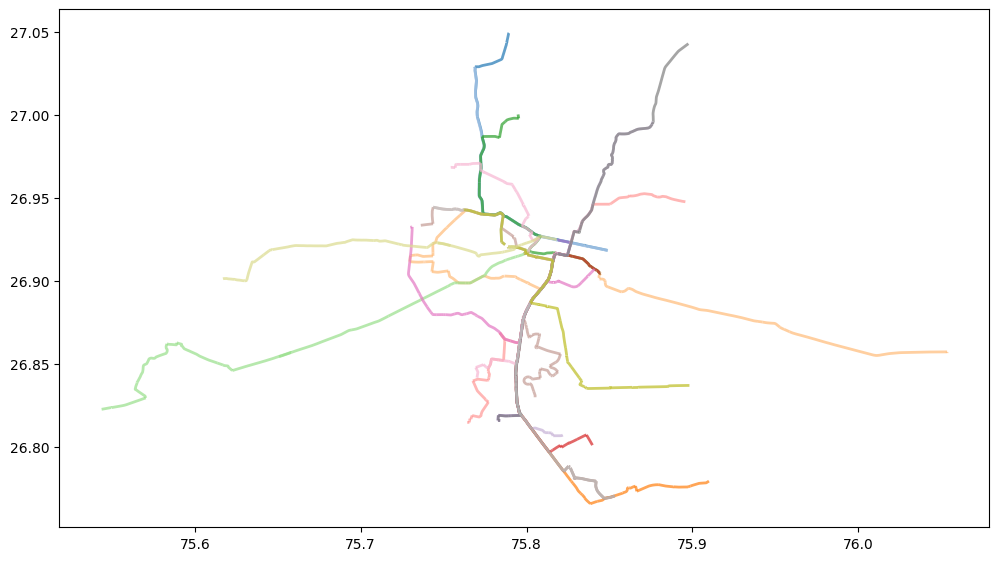

In [292]:
fig, ax = plt.subplots(figsize=(12, 12))
gdf_bus.plot(ax=ax, color=gdf_bus['color'], linewidth=2, label='Bus', alpha=0.7)
plt.show()

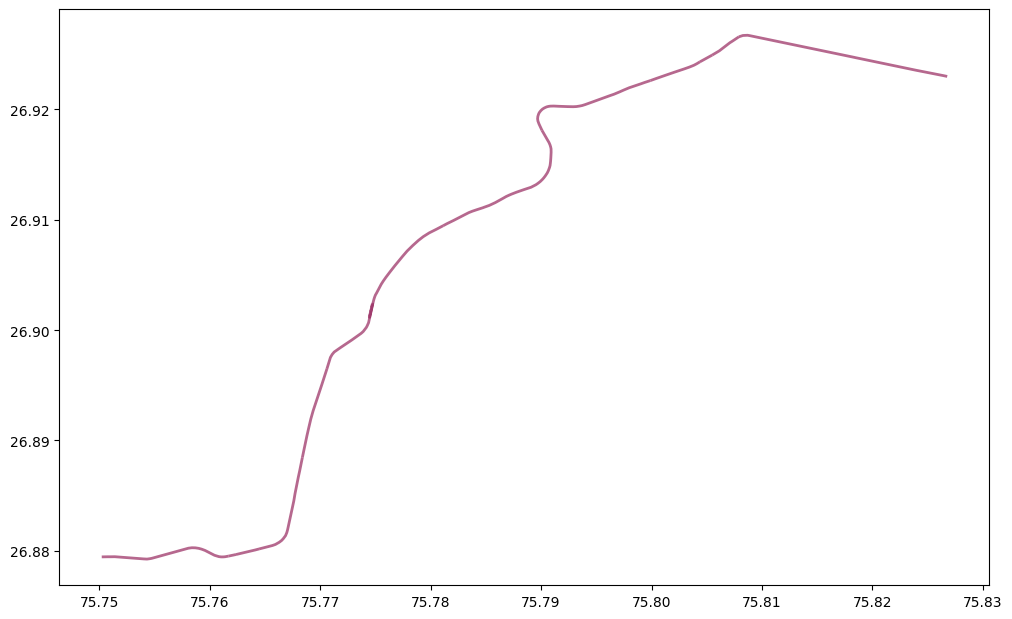

In [293]:
fig, ax = plt.subplots(figsize=(12, 12))
gdf_metro.plot(ax=ax, color=gdf_metro['color'], linewidth=2, label='Train', alpha=0.7)
plt.show()

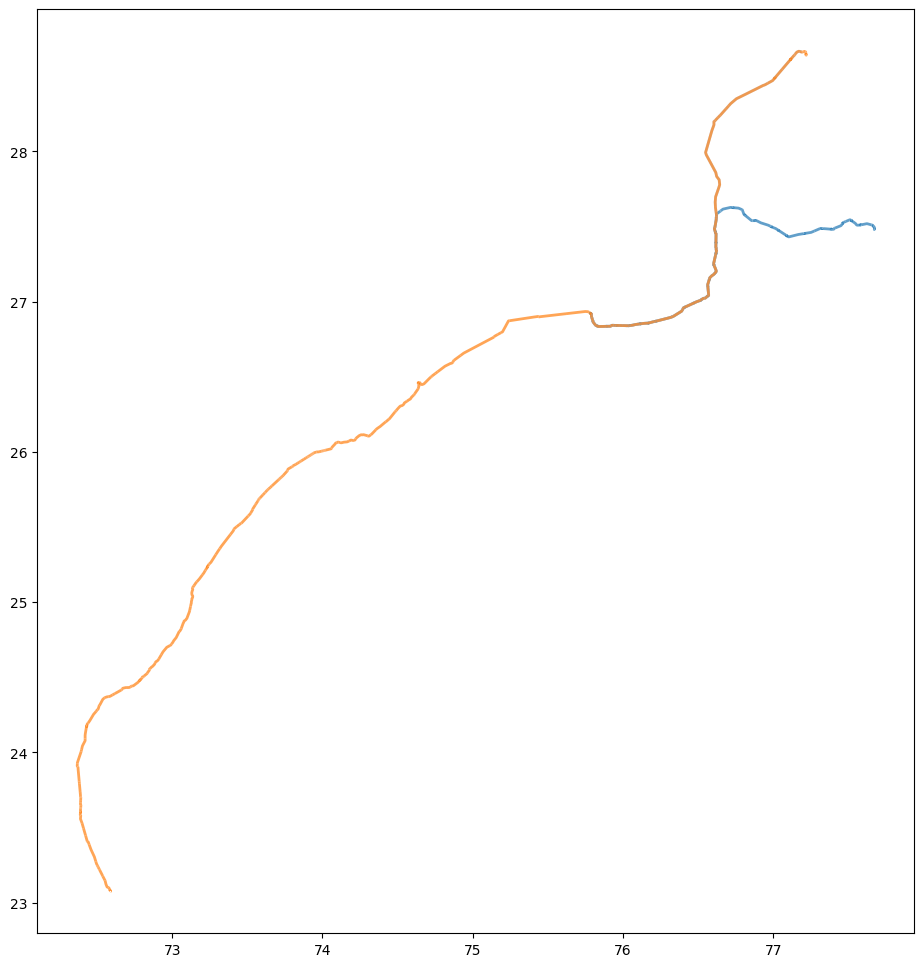

In [294]:
fig, ax = plt.subplots(figsize=(12, 12))
gdf_train.plot(ax=ax, color=gdf_train['color'], linewidth=2, label='Train', alpha=0.7)
plt.show()

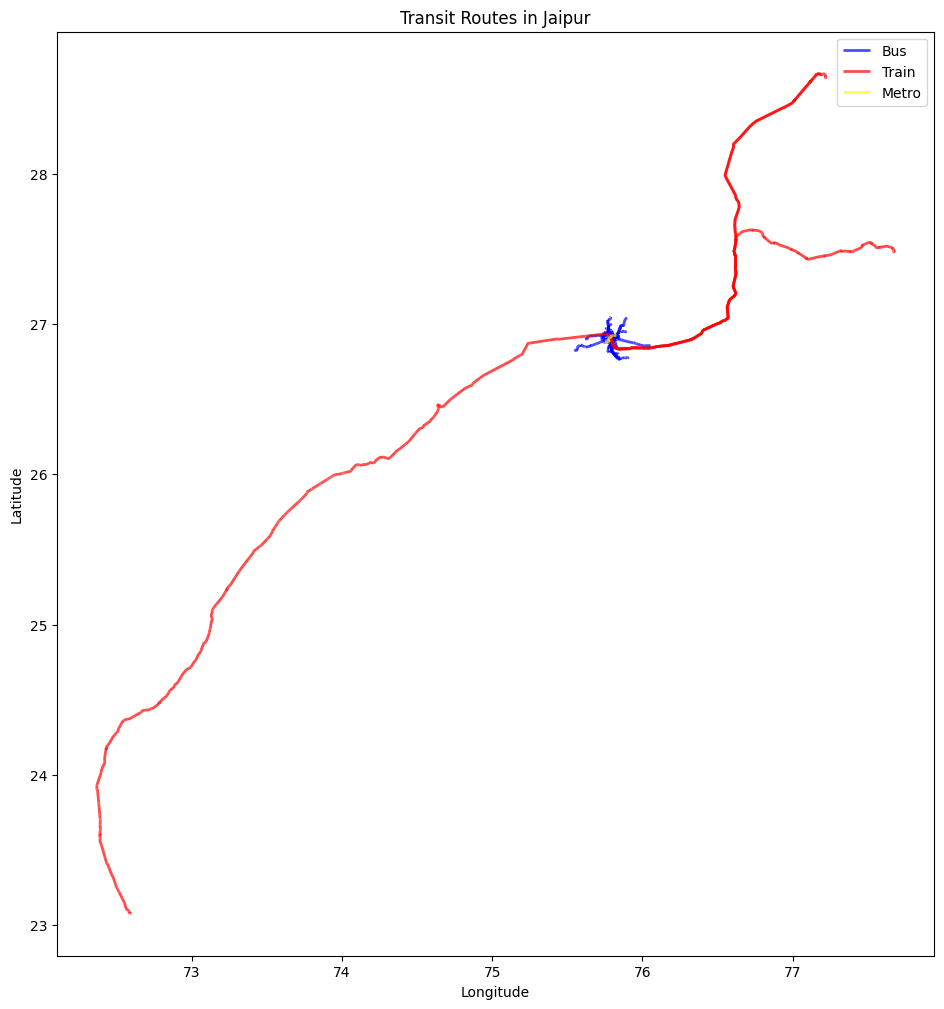

In [295]:
fig, ax = plt.subplots(figsize=(12, 12))
gdf_bus.plot(ax=ax, color='blue', linewidth=2, label='Bus', alpha=0.7)
gdf_train.plot(ax=ax, color='red', linewidth=2, label='Train', alpha=0.7)
gdf_metro.plot(ax=ax, color='yellow', linewidth=2, label='Metro', alpha=0.7)
ax.set_title("Transit Routes in Jaipur")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()

In [296]:
# COnvert to Geojson
gdf_bus.to_file("../../public/data/mapMain/bus_routes.geojson", driver='GeoJSON')
gdf_train.to_file("../../public/data/mapMain/train_routes.geojson", driver='GeoJSON')
gdf_metro.to_file("../../public/data/mapMain/metro_routes.geojson", driver='GeoJSON')